In [ ]:
#!/usr/bin/env python3
import os
import json
import random

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datasets import Dataset, DatasetDict
from transformers import (
    BertTokenizerFast,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
)
from transformers import AutoTokenizer, AutoModel

!pip install transformers
!pip install datasets
!pip install evaluate
!pip install seqeval
import evaluate

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
os.environ.setdefault("HF_DATASETS_DISABLE_MP", "1")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Configurations
INPUT_CSV = "/content/drive/My Drive/DS266/Final Project/data/absa_features_with_spans_withgpt.csv"
TEXT_COL = "Catalyst"
SPAN_COL = "auto_spans"
MODEL_NAME = "bert-base-cased"
MAX_LENGTH = 256
VAL_FRACTION = 0.2
SEED = 42

# Create the BIO tags

In [5]:
def char_spans_to_word_bio(text, span_dicts):
    """
    text: raw string
    span_dicts: list of {"start": int, "end": int, "label": "EFF_POS", ...}
    Returns:
      tokens: [str, ...]
      bio_tags: [str, ...] like "B-EFF_POS", "I-EFF_POS", "O"
    """

    if text is None:
        text = ""
    text = str(text)

    # simple word tokenization for now; you can swap in nltk/spacy if needed
    tokens = text.split()




    if not tokens:
        return [], []

    # convert spans to list of tuples for convenience
    spans = [(s["start"], s["end"], s["label"]) for s in span_dicts]

    # for each token, compute its char start/end (based on find from current offset)
    bio_tags = []
    offset = 0
    prev_underlying = None

    for tok in tokens:
        start = text.find(tok, offset)
        if start == -1:  # fallback if not found
            start = offset
        end = start + len(tok)
        offset = end

        # find all spans that fully contain this token
        candidates = [
            (s_start, s_end, lab)
            for (s_start, s_end, lab) in spans
            if start >= s_start and end <= s_end
        ]

        if not candidates:
            bio_tags.append("O")
            prev_underlying = None
            continue

        # if multiple, choose the longest span (or just first)
        s_start, s_end, lab = sorted(
            candidates,
            key=lambda x: (x[0], -(x[1] - x[0]))
        )[0]

        # underlying semantic label, e.g. "EFF_POS"
        underlying = lab

        # Decide B- vs I-:
        if prev_underlying == underlying:
            tag = f"I-{underlying}"
        else:
            tag = f"B-{underlying}"

        bio_tags.append(tag)
        prev_underlying = underlying

    return tokens, bio_tags

In [6]:
def load_ner_dataset(csv_path):
    df = pd.read_csv(csv_path)

    # Parse JSON spans and build tokens + BIO
    ner_rows = []
    for _, row in df.iterrows():
        text = row.get(TEXT_COL, "")
        spans_raw = row.get(SPAN_COL, "[]")
        try:
            span_dicts = json.loads(spans_raw) if isinstance(spans_raw, str) else spans_raw
        except json.JSONDecodeError:
            span_dicts = []

        tokens, bio = char_spans_to_word_bio(text, span_dicts)

        if not tokens:
            continue

        row_dict = row.to_dict()

        # Add new NER-specific fields
        row_dict["tokens"] = tokens
        row_dict["ner_tags_str"] = bio

        ner_rows.append(row_dict)

    # Build HF Dataset with all columns preserved
    dataset = Dataset.from_pandas(pd.DataFrame(ner_rows), preserve_index=False)
    return dataset

In [7]:
def build_labels(dataset):
    all_tags = set(tag for seq in dataset["ner_tags_str"] for tag in seq)
    # ensure deterministic ordering: O first, then others sorted
    label_list = ["O"] + sorted(t for t in all_tags if t != "O")
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}
    return label_list, label2id, id2label

In [8]:
def tokenize_and_align_labels(examples, tokenizer, label2id):
    # examples["tokens"] is a list of lists of tokens
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

    all_labels = []
    for i, word_labels in enumerate(examples["ner_tags_str"]):
        word_ids = tokenized.word_ids(batch_index=i)
        labels = []
        prev_word_id = None
        for word_id in word_ids:
            if word_id is None:
                labels.append(-100)
            else:
                # For subwords: only label the first subword
                if word_id != prev_word_id:
                    tag = word_labels[word_id]
                    labels.append(label2id[tag])
                else:
                    # set to -100 so loss ignores
                    labels.append(-100)
            prev_word_id = word_id
        all_labels.append(labels)

    tokenized["labels"] = all_labels
    return tokenized

In [9]:
seqeval_metric = evaluate.load("seqeval")

def compute_metrics(p, label_list):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    true_labels = []
    true_preds  = []

    for pred, lab in zip(predictions, labels):
        cur_preds = []
        cur_labels = []
        for p_i, l_i in zip(pred, lab):
            if l_i == -100:
                continue
            cur_preds.append(label_list[p_i])
            cur_labels.append(label_list[l_i])
        true_preds.append(cur_preds)
        true_labels.append(cur_labels)

    results = seqeval_metric.compute(predictions=true_preds, references=true_labels)
    # results is like {'overall_precision': ..., 'overall_recall': ..., 'overall_f1': ..., 'overall_accuracy': ...}
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
def evaluate_ner(trainer, tokenized_dataset_split, id2label, seqeval_metric):
    """
    Evaluate a token classification model on a dataset split.

    Returns:
      results_full_df: pandas DataFrame with per-label and overall metrics
      true_preds: list of predicted label sequences (BIO)
      true_labels: list of true label sequences (BIO)
      pred_ids: raw predicted label IDs
    """
    # 1) Predict
    predictions_output = trainer.predict(tokenized_dataset_split)
    logits = predictions_output.predictions
    labels = predictions_output.label_ids

    # 2) Convert logits → predicted IDs
    pred_ids = logits.argmax(axis=-1)

    # 3) Convert IDs → BIO label strings (ignoring -100)
    true_preds = []
    true_labels = []

    for pred_row, label_row in zip(pred_ids, labels):
        pred_seq = []
        label_seq = []

        for p, l in zip(pred_row, label_row):
            if l == -100:
                continue
            pred_seq.append(id2label[p])
            label_seq.append(id2label[l])

        true_preds.append(pred_seq)
        true_labels.append(label_seq)

    # 4) Compute seqeval metrics
    results = seqeval_metric.compute(
        predictions=true_preds,
        references=true_labels
    )

    # 5) Build dataframe
    label_keys = [k for k in results.keys() if not k.startswith("overall")]

    results_df = pd.DataFrame.from_dict(
        {k: results[k] for k in label_keys},
        orient="index"
    )

    results_df_overall = pd.DataFrame([{
        "accuracy": results["overall_accuracy"],
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "number": None
    }], index=["OVERALL"])

    results_full_df = pd.concat([results_df, results_df_overall])

    return results_full_df, true_preds, true_labels, pred_ids

In [11]:
# function to save the information from the model
def save_ner_artifacts(
    folder,
    id2label,
    label2id,
    eval_results,
    seqeval_metric,
    true_preds,
    true_labels,
    ds,
    tokenized_ds,
    pred_ids,
    results_full_df,
):
    """
    Saves all NER evaluation artifacts:
    - labels.json
    - metrics.json
    - seqeval per-label text report
    - per-label CSV table
    - predictions.jsonl with tokens + decoded labels
    - confusion_matrix.txt
    """

    # Ensure folder exists
    os.makedirs(folder, exist_ok=True)

    # ------------------ SAVE LABEL MAP ------------------
    with open(f"{folder}/labels.json", "w") as f:
        json.dump({"id2label": id2label, "label2id": label2id}, f, indent=2)

    # ------------------ SAVE METRICS ---------------------
    with open(f"{folder}/metrics.json", "w") as f:
        json.dump(eval_results, f, indent=2)

    # ------------------ DETAILED LABEL REPORT -------------
    detailed = seqeval_metric.compute(
        predictions=true_preds,
        references=true_labels
    )
    with open(f"{folder}/per_label_report.txt", "w") as f:
        for label, vals in detailed.items():
            f.write(f"{label}: {vals}\n")

    # ------------------ SAVE RESULTS CSV ------------------
    results_full_df.to_csv(
        f"{folder}/ner_per_label_metrics.csv",
        index=True
    )

    # ------------------ SAVE PREDICTIONS JSONL ------------------
    with open(f"{folder}/predictions.jsonl", "w") as f:
        for tokens, pred_seq, true_seq in zip(
            ds["test"]["tokens"],
            pred_ids,
            tokenized_ds["test"]["labels"]
        ):
            decoded_pred = []
            decoded_true = []

            for p, t in zip(pred_seq, true_seq):
                if t == -100:
                    continue
                decoded_pred.append(id2label[p])
                decoded_true.append(id2label[t])

            f.write(json.dumps({
                "tokens": tokens,
                "predicted": decoded_pred,
                "true": decoded_true
            }) + "\n")

    # ------------------ CONFUSION MATRIX ------------------
    flat_pred = [p for seq in true_preds for p in seq]
    flat_true = [t for seq in true_labels for t in seq]

    labels_sorted = sorted(list(set(flat_true)))

    cm = confusion_matrix(flat_true, flat_pred, labels=labels_sorted)
    np.savetxt(f"{folder}/confusion_matrix.txt", cm, fmt="%d")

    print(f"All NER artifacts saved to: {folder}")

# Load data, train and evaluate model using Basic BERT Model

In [12]:
# load in the NER dataset using function that makes the spans in BIO
dataset = load_ner_dataset(INPUT_CSV)

# build labels
label_list, label2id, id2label = build_labels(dataset)
num_labels = len(label_list)
print("Labels:", label_list)

# split into training and testing set
dates = pd.to_datetime(dataset["Date"])
cutoff_date =  pd.to_datetime("2024-10-01")
train_idx = [i for i, d in enumerate(dates) if d <= cutoff_date]
test_idx  = [i for i, d in enumerate(dates) if d > cutoff_date]

ds = DatasetDict({
        "train": dataset.select(train_idx),
        "test": dataset.select(test_idx),
    })


Labels: ['O', 'B-CLIN_NEG', 'B-CLIN_POS', 'B-CONF_POS', 'B-EFF_NEG', 'B-EFF_POS', 'B-ENROLL_NEG', 'B-ENROLL_POS', 'B-REG_NEG', 'B-REG_NEUTRAL', 'B-REG_POS', 'B-SAFETY_NEG', 'B-SAFETY_POS', 'I-CLIN_NEG', 'I-CLIN_POS', 'I-CONF_POS', 'I-EFF_NEG', 'I-EFF_POS', 'I-ENROLL_NEG', 'I-ENROLL_POS', 'I-REG_NEG', 'I-REG_POS', 'I-SAFETY_NEG', 'I-SAFETY_POS']


In [13]:
# tokenize
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

def _tokenize(examples):
    return tokenize_and_align_labels(examples, tokenizer, label2id)

tokenized_ds = ds.map(_tokenize, batched=True, remove_columns=["tokens", "ner_tags_str"])


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/2092 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [14]:
# using bert-base-case first
model = AutoModelForTokenClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
folder = '/content/drive/My Drive/DS266/Final Project/runs/bert_ner_v1'

training_args = TrainingArguments(
        output_dir="/content/drive/My Drive/DS266/Final Project/models/bert_ner_v1",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=SEED,
        logging_dir=f"{folder}/logs",
        report_to=["tensorboard"],
    )

In [16]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, label_list),
    )

/tmp/ipython-input-162134233.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.559500,0.577111,0.130477,0.150731,0.139875,0.792719
2,0.423500,0.484561,0.185798,0.214848,0.199270,0.828567
3,0.331700,0.483266,0.222222,0.238470,0.230060,0.837989
4,0.271300,0.497767,0.214785,0.241845,0.227513,0.837598
5,0.235900,0.533447,0.212575,0.239595,0.225278,0.839605


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

TrainOutput(global_step=1310, training_loss=0.3933454422550347, metrics={'train_runtime': 176.4632, 'train_samples_per_second': 59.276, 'train_steps_per_second': 7.424, 'total_flos': 1366853851791360.0, 'train_loss': 0.3933454422550347, 'epoch': 5.0})

In [18]:
os.makedirs(folder, exist_ok=True)
trainer.model.config.to_json_file(f"{folder}/config.json")

In [19]:
eval_results = trainer.evaluate()
print("Final eval:", eval_results)

Final eval: {'eval_loss': 0.4832662343978882, 'eval_precision': 0.2222222222222222, 'eval_recall': 0.23847019122609675, 'eval_f1': 0.2300596852957135, 'eval_accuracy': 0.8379885153593132, 'eval_runtime': 3.7448, 'eval_samples_per_second': 218.438, 'eval_steps_per_second': 27.505, 'epoch': 5.0}


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
results_full_df, true_preds, true_labels, pred_ids = evaluate_ner(
    trainer,
    tokenized_ds["test"],
    id2label,
    seqeval_metric
)

results_full_df


,precision,recall,f1,number,accuracy
CLIN_NEG,0.000000,0.000000,0.000000,11,NaN
CLIN_POS,0.357143,0.277778,0.312500,36,NaN
CONF_POS,0.000000,0.000000,0.000000,2,NaN
EFF_NEG,0.186047,0.216216,0.200000,37,NaN
EFF_POS,0.158833,0.169844,0.164154,577,NaN
ENROLL_NEG,0.000000,0.000000,0.000000,4,NaN
ENROLL_POS,0.291667,0.500000,0.368421,14,NaN
REG_NEG,0.500000,0.277778,0.357143,18,NaN
REG_POS,0.477778,0.483146,0.480447,89,NaN
SAFETY_NEG,0.000000,0.000000,0.000000,6,NaN


## Putting these numbers into context with baseline

In [21]:
baseline_preds = [["O"] * len(seq) for seq in true_labels]

baseline_results = seqeval_metric.compute(
    predictions=baseline_preds,
    references=true_labels
)

label_keys = [k for k in baseline_results.keys() if not k.startswith("overall")]
baseline_df = pd.DataFrame.from_dict(
    {k: baseline_results[k] for k in label_keys},
    orient="index"
)

baseline_df_overall = pd.DataFrame([{
    "accuracy":  baseline_results["overall_accuracy"],
    "precision": baseline_results["overall_precision"],
    "recall":    baseline_results["overall_recall"],
    "f1":        baseline_results["overall_f1"],
    "number":    None
}], index=["OVERALL"])

baseline_full_df = pd.concat([baseline_df, baseline_df_overall])
baseline_full_df



/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1,number,accuracy
CLIN_NEG,0.0,0.0,0.0,11,NaN
CLIN_POS,0.0,0.0,0.0,36,NaN
CONF_POS,0.0,0.0,0.0,2,NaN
EFF_NEG,0.0,0.0,0.0,37,NaN
EFF_POS,0.0,0.0,0.0,577,NaN
ENROLL_NEG,0.0,0.0,0.0,4,NaN
ENROLL_POS,0.0,0.0,0.0,14,NaN
REG_NEG,0.0,0.0,0.0,18,NaN
REG_POS,0.0,0.0,0.0,89,NaN
SAFETY_NEG,0.0,0.0,0.0,6,NaN


In [22]:
# save the results
save_ner_artifacts(
    folder=folder,
    id2label=id2label,
    label2id=label2id,
    eval_results=eval_results,
    seqeval_metric=seqeval_metric,
    true_preds=true_preds,
    true_labels=true_labels,
    ds=ds,
    tokenized_ds=tokenized_ds,
    pred_ids=pred_ids,
    results_full_df=results_full_df
)


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All NER artifacts saved to: /content/drive/My Drive/DS266/Final Project/runs/bert_ner_v1


# Trying Modern BERT Model



In [23]:
MODEL_NAME = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [24]:
model_modern = AutoModelForTokenClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForTokenClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
folder = '/content/drive/My Drive/DS266/Final Project/runs/bert_modern_ner_v1'

training_args_modern = TrainingArguments(
        output_dir="/content/drive/My Drive/DS266/Final Project/models/bert_modern_ner_v1",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=SEED,
        logging_dir=f"{folder}/logs",
        report_to=["tensorboard"],
    )

In [26]:
trainer_modern = Trainer(
        model=model_modern,
        args=training_args_modern,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, label_list),
    )

/tmp/ipython-input-1816871005.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_modern = Trainer(


In [27]:
trainer_modern.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:312: U

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.666500,0.626423,0.090571,0.082115,0.086136,0.801583
2,0.491000,0.575218,0.149413,0.157480,0.153341,0.807326
3,0.371200,0.588885,0.194478,0.182227,0.188153,0.820037
4,0.259800,0.640821,0.175474,0.197975,0.186047,0.815632
5,0.175900,0.736137,0.177645,0.200225,0.188260,0.814908


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

TrainOutput(global_step=1310, training_loss=0.4262756641584498, metrics={'train_runtime': 251.968, 'train_samples_per_second': 41.513, 'train_steps_per_second': 5.199, 'total_flos': 1782435348725760.0, 'train_loss': 0.4262756641584498, 'epoch': 5.0})

In [28]:
os.makedirs(folder, exist_ok=True)
trainer_modern.model.config.to_json_file(f"{folder}/config.json")

In [29]:
eval_results_modern = trainer_modern.evaluate()
print("Final eval:", eval_results_modern)

Final eval: {'eval_loss': 0.7361373901367188, 'eval_precision': 0.17764471057884232, 'eval_recall': 0.20022497187851518, 'eval_f1': 0.1882601797990481, 'eval_accuracy': 0.8149077326197246, 'eval_runtime': 4.641, 'eval_samples_per_second': 176.257, 'eval_steps_per_second': 22.194, 'epoch': 5.0}


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
results_full_df_modern, true_preds_modern, true_labels_modern, pred_ids_modern = evaluate_ner(
    trainer_modern,
    tokenized_ds["test"],
    id2label,
    seqeval_metric
)

results_full_df_modern

,precision,recall,f1,number,accuracy
CLIN_NEG,0.000000,0.000000,0.000000,11,NaN
CLIN_POS,0.268293,0.305556,0.285714,36,NaN
CONF_POS,0.000000,0.000000,0.000000,2,NaN
EFF_NEG,0.160714,0.243243,0.193548,37,NaN
EFF_POS,0.119645,0.140381,0.129187,577,NaN
ENROLL_NEG,0.000000,0.000000,0.000000,4,NaN
ENROLL_POS,0.250000,0.428571,0.315789,14,NaN
REG_NEG,0.461538,0.333333,0.387097,18,NaN
REG_POS,0.377778,0.382022,0.379888,89,NaN
SAFETY_NEG,0.000000,0.000000,0.000000,6,NaN


In [31]:
# saving results
save_ner_artifacts(
    folder=folder,
    id2label=id2label,
    label2id=label2id,
    eval_results=eval_results_modern,
    seqeval_metric=seqeval_metric,
    true_preds=true_preds,
    true_labels=true_labels,
    ds=ds,
    tokenized_ds=tokenized_ds,
    pred_ids=pred_ids,
    results_full_df=results_full_df_modern
)

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All NER artifacts saved to: /content/drive/My Drive/DS266/Final Project/runs/bert_modern_ner_v1


# Trying BioBERT

In [32]:
MODEL_NAME = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [33]:
model_biobert = AutoModelForTokenClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
folder = '/content/drive/My Drive/DS266/Final Project/runs/bert_biobert_ner_v1'

training_args_biobert = TrainingArguments(
        output_dir="/content/drive/My Drive/DS266/Final Project/models/bert_biobert_ner_v1",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=SEED,
        logging_dir=f"{folder}/logs",
        report_to=["tensorboard"],
    )

In [35]:
trainer_biobert = Trainer(
        model=model_biobert,
        args=training_args_biobert,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, label_list),
    )

/tmp/ipython-input-1960334025.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_biobert = Trainer(


In [36]:
trainer_biobert.train()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.553300,0.551859,0.172708,0.182227,0.177340,0.806211
2,0.428200,0.477419,0.204431,0.228346,0.215728,0.832692
3,0.330500,0.479768,0.239861,0.232846,0.236301,0.837431
4,0.279000,0.482927,0.217606,0.247469,0.231579,0.838936
5,0.232800,0.519108,0.230270,0.239595,0.234840,0.840219


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

TrainOutput(global_step=1310, training_loss=0.3937992120517119, metrics={'train_runtime': 174.7946, 'train_samples_per_second': 59.842, 'train_steps_per_second': 7.495, 'total_flos': 1366853851791360.0, 'train_loss': 0.3937992120517119, 'epoch': 5.0})

In [37]:
os.makedirs(folder, exist_ok=True)
trainer_biobert.model.config.to_json_file(f"{folder}/config.json")

In [38]:
eval_results_biobert = trainer_biobert.evaluate()
print("Final eval:", eval_results_biobert)

Final eval: {'eval_loss': 0.47976773977279663, 'eval_precision': 0.2398609501738123, 'eval_recall': 0.23284589426321708, 'eval_f1': 0.2363013698630137, 'eval_accuracy': 0.8374310085298545, 'eval_runtime': 3.7734, 'eval_samples_per_second': 216.781, 'eval_steps_per_second': 27.296, 'epoch': 5.0}


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
results_full_df_biobert, true_preds_biobert, true_labels_biobert, pred_ids_biobert = evaluate_ner(
    trainer_biobert,
    tokenized_ds["test"],
    id2label,
    seqeval_metric
)

results_full_df_biobert

,precision,recall,f1,number,accuracy
CLIN_NEG,0.000000,0.000000,0.000000,11,NaN
CLIN_POS,0.476190,0.277778,0.350877,36,NaN
CONF_POS,0.000000,0.000000,0.000000,2,NaN
EFF_NEG,0.148936,0.189189,0.166667,37,NaN
EFF_POS,0.165756,0.157712,0.161634,577,NaN
ENROLL_NEG,0.000000,0.000000,0.000000,4,NaN
ENROLL_POS,0.500000,0.642857,0.562500,14,NaN
REG_NEG,0.312500,0.277778,0.294118,18,NaN
REG_POS,0.506024,0.471910,0.488372,89,NaN
SAFETY_NEG,0.000000,0.000000,0.000000,6,NaN


In [40]:
# saving results
save_ner_artifacts(
    folder=folder,
    id2label=id2label,
    label2id=label2id,
    eval_results=eval_results_biobert,
    seqeval_metric=seqeval_metric,
    true_preds=true_preds,
    true_labels=true_labels,
    ds=ds,
    tokenized_ds=tokenized_ds,
    pred_ids=pred_ids,
    results_full_df=results_full_df_biobert
)

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All NER artifacts saved to: /content/drive/My Drive/DS266/Final Project/runs/bert_biobert_ner_v1


# Checking the FinBERT model



yiyanghkust/finbert-tone

In [41]:
MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [42]:
model_finbert = AutoModelForTokenClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([24, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
folder = '/content/drive/My Drive/DS266/Final Project/runs/bert_finbert_ner_v1'

training_args_finbert = TrainingArguments(
        output_dir="/content/drive/My Drive/DS266/Final Project/models/bert_finbert_ner_v1",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=SEED,
        logging_dir=f"{folder}/logs",
        report_to=["tensorboard"],
    )

In [44]:
trainer_finbert = Trainer(
        model=model_finbert,
        args=training_args_finbert,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, label_list),
    )

/tmp/ipython-input-2389471853.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_finbert = Trainer(


In [45]:
trainer_finbert.train()

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.641100,0.661817,0.092409,0.094488,0.093437,0.773429
2,0.516400,0.559541,0.149837,0.155231,0.152486,0.813960
3,0.441900,0.550274,0.191106,0.178853,0.184776,0.824441
4,0.373000,0.549134,0.183742,0.185602,0.184667,0.823605
5,0.329000,0.570422,0.196388,0.195726,0.196056,0.825668


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

TrainOutput(global_step=1310, training_loss=0.48592832561667637, metrics={'train_runtime': 174.2658, 'train_samples_per_second': 60.023, 'train_steps_per_second': 7.517, 'total_flos': 1366853851791360.0, 'train_loss': 0.48592832561667637, 'epoch': 5.0})

In [46]:
os.makedirs(folder, exist_ok=True)
trainer_finbert.model.config.to_json_file(f"{folder}/config.json")

In [47]:
eval_results_finbert = trainer_finbert.evaluate()
print("Final eval:", eval_results_finbert)

Final eval: {'eval_loss': 0.5704222321510315, 'eval_precision': 0.1963882618510158, 'eval_recall': 0.19572553430821146, 'eval_f1': 0.19605633802816902, 'eval_accuracy': 0.8256676144282767, 'eval_runtime': 3.7535, 'eval_samples_per_second': 217.932, 'eval_steps_per_second': 27.441, 'epoch': 5.0}


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
results_full_df_finbert, true_preds_finbert, true_labels_finbert, pred_ids_finbert = evaluate_ner(
    trainer_finbert,
    tokenized_ds["test"],
    id2label,
    seqeval_metric
)

results_full_df_finbert

,precision,recall,f1,number,accuracy
CLIN_NEG,0.000000,0.000000,0.000000,11,NaN
CLIN_POS,0.370370,0.277778,0.317460,36,NaN
CONF_POS,0.000000,0.000000,0.000000,2,NaN
EFF_NEG,0.137255,0.189189,0.159091,37,NaN
EFF_POS,0.116638,0.117851,0.117241,577,NaN
ENROLL_NEG,0.000000,0.000000,0.000000,4,NaN
ENROLL_POS,0.206897,0.428571,0.279070,14,NaN
REG_NEG,0.555556,0.277778,0.370370,18,NaN
REG_POS,0.461538,0.471910,0.466667,89,NaN
SAFETY_NEG,0.000000,0.000000,0.000000,6,NaN


In [49]:
# saving results
save_ner_artifacts(
    folder=folder,
    id2label=id2label,
    label2id=label2id,
    eval_results=eval_results_finbert,
    seqeval_metric=seqeval_metric,
    true_preds=true_preds,
    true_labels=true_labels,
    ds=ds,
    tokenized_ds=tokenized_ds,
    pred_ids=pred_ids,
    results_full_df=results_full_df_finbert
)

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All NER artifacts saved to: /content/drive/My Drive/DS266/Final Project/runs/bert_finbert_ner_v1


# Trying PubMedBERT

NeuML/pubmedbert-base-embeddings

In [50]:
MODEL_NAME = "NeuML/pubmedbert-base-embeddings"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [51]:
model_pubmedbert = AutoModelForTokenClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at NeuML/pubmedbert-base-embeddings and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
folder = '/content/drive/My Drive/DS266/Final Project/runs/bert_pubmedbert_ner_v1'

training_args_pubmedbert = TrainingArguments(
        output_dir="/content/drive/My Drive/DS266/Final Project/models/bert_pubmedbert_ner_v1",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=SEED,
        logging_dir=f"{folder}/logs",
        report_to=["tensorboard"],
    )

In [53]:
trainer_pubmedbert = Trainer(
        model=model_pubmedbert,
        args=training_args_pubmedbert,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, label_list),
    )

/tmp/ipython-input-2077433490.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pubmedbert = Trainer(


In [54]:
trainer_pubmedbert.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.704300,0.714902,0.056075,0.047244,0.051282,0.735630
2,0.585400,0.597339,0.146530,0.128234,0.136773,0.793834
3,0.499900,0.562211,0.156962,0.139483,0.147707,0.815186
4,0.448100,0.558593,0.151692,0.146232,0.148912,0.814796
5,0.404800,0.570910,0.160047,0.154106,0.157020,0.817974


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

TrainOutput(global_step=1310, training_loss=0.5498470630354554, metrics={'train_runtime': 150.5278, 'train_samples_per_second': 69.489, 'train_steps_per_second': 8.703, 'total_flos': 1366853851791360.0, 'train_loss': 0.5498470630354554, 'epoch': 5.0})

In [55]:
os.makedirs(folder, exist_ok=True)
trainer_pubmedbert.model.config.to_json_file(f"{folder}/config.json")

In [56]:
eval_results_pubmedbert = trainer_pubmedbert.evaluate()
print("Final eval:", eval_results_pubmedbert)

Final eval: {'eval_loss': 0.5709100961685181, 'eval_precision': 0.16004672897196262, 'eval_recall': 0.15410573678290213, 'eval_f1': 0.15702005730659024, 'eval_accuracy': 0.8179740201817473, 'eval_runtime': 3.6907, 'eval_samples_per_second': 221.639, 'eval_steps_per_second': 27.908, 'epoch': 5.0}


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
results_full_df_pubmedbert, true_preds_pubmedbert, true_labels_pubmedbert, pred_ids_pubmedbert = evaluate_ner(
    trainer_pubmedbert,
    tokenized_ds["test"],
    id2label,
    seqeval_metric
)

results_full_df_pubmedbert

,precision,recall,f1,number,accuracy
CLIN_NEG,0.000000,0.000000,0.000000,11,NaN
CLIN_POS,0.454545,0.277778,0.344828,36,NaN
CONF_POS,0.000000,0.000000,0.000000,2,NaN
EFF_NEG,0.170732,0.189189,0.179487,37,NaN
EFF_POS,0.113835,0.112652,0.113240,577,NaN
ENROLL_NEG,0.000000,0.000000,0.000000,4,NaN
ENROLL_POS,0.214286,0.428571,0.285714,14,NaN
REG_NEG,0.750000,0.166667,0.272727,18,NaN
REG_POS,0.149533,0.179775,0.163265,89,NaN
SAFETY_NEG,0.000000,0.000000,0.000000,6,NaN


In [58]:
# saving results
save_ner_artifacts(
    folder=folder,
    id2label=id2label,
    label2id=label2id,
    eval_results=eval_results_pubmedbert,
    seqeval_metric=seqeval_metric,
    true_preds=true_preds,
    true_labels=true_labels,
    ds=ds,
    tokenized_ds=tokenized_ds,
    pred_ids=pred_ids,
    results_full_df=results_full_df_pubmedbert
)

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All NER artifacts saved to: /content/drive/My Drive/DS266/Final Project/runs/bert_pubmedbert_ner_v1


# Comparison of each of the model's results on F1 Score

Initialize an empty pandas DataFrame for comparison, indexed by `label_list`. Then, for each model's full results DataFrame (`baseline_full_df`, `results_full_df`, `results_full_df_modern`, `results_full_df_biobert`, `results_full_df_pubmedbert`, `results_full_df_finbert`), extract the 'f1' column (excluding the 'OVERALL' row), rename it to the model's name, and add it to the comparison DataFrame. Finally, display the complete comparison table.

In [67]:
compare_results = pd.DataFrame(index=results_full_df.index)
models = ['Baseline (All classified as "O")', "BERT-Base", "Modern BERT", "BioBERT", "PubMedBERT", "FinBERT"]
for i, dataset in enumerate([baseline_full_df, results_full_df, results_full_df_modern, results_full_df_biobert, results_full_df_pubmedbert, results_full_df_finbert]):
  model = models[i]
  compare_results[model] = dataset['f1']

compare_results.to_csv("/content/drive/My Drive/DS266/Final Project/data/model_comparison_f1.csv", )


# Finetune the BIO Bert Model to maximize the F1 score

In [ ]:
MODEL_NAME = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

#  re-tokenize the dataset since we are using a different tokenizer (BioBERT)
def _tokenize_bio(examples):
    return tokenize_and_align_labels(examples, tokenizer, label2id)

print("Tokenizing for BioBERT...")
tokenized_ds_bio = ds.map(_tokenize_bio, batched=True, remove_columns=ds["train"].column_names)

#  simple Grid Search Loop
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8,16,32]
num_epochs = 5

search_results = []

print(f"Starting Hyperparameter Search over LRs={learning_rates} and BS={batch_sizes}...")

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n=== Training with LR={lr}, BS={bs} ===")

        # Reload model each time to start with fresh weights
        model = AutoModelForTokenClassification.from_pretrained(
            MODEL_NAME,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
        )

        run_name = f"biobert_lr{lr}_bs{bs}"
        output_dir = f"/content/drive/My Drive/DS266/Final Project/models/hp_search/{run_name}"

        args = TrainingArguments(
            output_dir=output_dir,
            eval_strategy="epoch",
            save_strategy="no",   # Do not save checkpoints to save disk space during search
            learning_rate=lr,
            per_device_train_batch_size=bs,
            per_device_eval_batch_size=bs,
            num_train_epochs=num_epochs,
            weight_decay=0.01,
            logging_steps=50,
            seed=SEED,
            report_to="none"      # Disable wandb/tensorboard for the search loop to reduce noise
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=tokenized_ds_bio["train"],
            eval_dataset=tokenized_ds_bio["test"],
            processing_class=tokenizer,
            compute_metrics=lambda p: compute_metrics(p, label_list),
        )

        trainer.train()
        eval_metrics = trainer.evaluate()

        print(f"--> F1: {eval_metrics['eval_f1']:.4f} | Accuracy: {eval_metrics['eval_accuracy']:.4f}")

        search_results.append({
            "lr": lr,
            "bs": bs,
            "f1": eval_metrics['eval_f1'],
            "accuracy": eval_metrics['eval_accuracy'],
            "precision": eval_metrics['eval_precision'],
            "recall": eval_metrics['eval_recall']
        })

# 3. Display Results
print("\n=== Hyperparameter Search Results ===")
df_results = pd.DataFrame(search_results).sort_values(by="f1", ascending=False)
print(df_results)

In [ ]:
folder = '/content/drive/My Drive/DS266/Final Project/runs/biobert_hp_search'
df_results.to_csv(
        f"{folder}/ner_per_label_metrics.csv",
        index=True
    )

Checking the lengths of the Catalyst

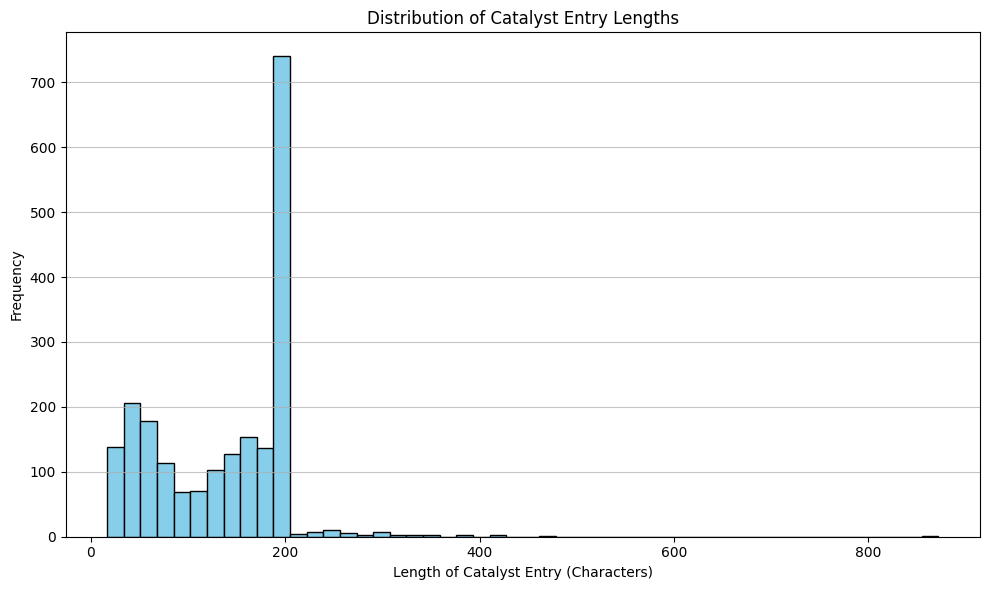

In [ ]:
catalyst_lengths = [len(item) for item in ds_train['Catalyst']]

plt.figure(figsize=(10, 6)) # Set a larger figure size
plt.hist(catalyst_lengths, bins=50, color='skyblue', edgecolor='black') # More bins, nicer color

plt.title('Distribution of Catalyst Entry Lengths') # Add a title
plt.xlabel('Length of Catalyst Entry (Characters)') # Add x-axis label
plt.ylabel('Frequency') # Add y-axis label
plt.grid(axis='y', alpha=0.75) # Add a grid

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig("/content/drive/My Drive/DS266/Final Project/BERT-BASE/out/catalyst_length_histogram.png", dpi=300)
plt.show()